In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv(r"data-clean-final.csv")

In [3]:
data.head()

Unnamed: 0        ID Case Number                 Date  \
0  2016-05-03 23:40:00  10508693    HZ250496  2016-05-03 23:40:00   
1  2016-05-03 21:40:00  10508695    HZ250409  2016-05-03 21:40:00   
2  2016-05-03 23:31:00  10508697    HZ250503  2016-05-03 23:31:00   
3  2016-05-03 22:10:00  10508698    HZ250424  2016-05-03 22:10:00   
4  2016-05-03 22:00:00  10508699    HZ250455  2016-05-03 22:00:00   

                 Block  IUCR            Primary Type              Description  \
0   013XX S SAWYER AVE  0486                 BATTERY  DOMESTIC BATTERY SIMPLE   
1   061XX S DREXEL AVE  0486                 BATTERY  DOMESTIC BATTERY SIMPLE   
2  053XX W CHICAGO AVE  0470  PUBLIC PEACE VIOLATION         RECKLESS CONDUCT   
3    049XX W FULTON ST  0460                 BATTERY                   SIMPLE   
4    003XX N LOTUS AVE  0820                   THEFT           $500 AND UNDER   

  Location Description  Arrest  ...  Y Coordinate  Year   Latitude  Longitude  \
0            APARTMENT    True  ...     1893681.0  2016  41.864073 -87.706819   
1            RESIDENCE   False  ...     1864330.0  2016  41.782922 -87.604363   
2               STREET   False  ...     1904819.0  2016  41.894908 -87.758372   
3             SIDEWALK   False  ...     1901475.0  2016  41.885687 -87.749516   
4            RESIDENCE   False  ...     1901675.0  2016  41.886297 -87.761751   

   Month dayOfWeek  dayOfMonth  dayOfYear  weekOfMonth  weekOfYear  
0      5         1           3        124            1          18  
1      5         1           3        124            1          18  
2      5         1           3        124            1          18  
3      5         1           3        124            1          18  
4      5         1           3        124            1          18  

[5 rows x 27 columns]

In [4]:
data.drop(['X Coordinate', 'Y Coordinate', 'Beat','Unnamed: 0'], axis=1, inplace=True)

In [5]:
data['Date'] = pd.to_datetime(data.Date) 
data['date'] = [d.date() for d in data['Date']]
data['time'] = [d.time() for d in data['Date']]

data['time'] = data['time'].astype(str)
empty_list = []
for timestr in data['time'].tolist():
    ftr = [3600,60,1]
    var = sum([a*b for a,b in zip(ftr, map(int,timestr.split(':')))])
    empty_list.append(var)
    
data['seconds'] = empty_list

In [6]:
sub_data = data[['Ward', 'IUCR', 'District']]
sub_data = sub_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
sub_data['IUCR'] = sub_data.IUCR.str.extract('(\d+)', expand=True).astype(int)
sub_data.head()

Ward  IUCR  District
0  24.0   486      10.0
1  20.0   486       3.0
2  37.0   470      15.0
3  28.0   460      15.0
4  28.0   820      15.0

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [9]:
N = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in N]
kmeans
score = [kmeans[i].fit(sub_data).score(sub_data) for i in range(len(kmeans))]
score
plt.plot(N,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show() 

In [10]:
km = KMeans(n_clusters=4)
km.fit(sub_data)
y = km.predict(sub_data)
labels = km.labels_
sub_data['Cluster'] = y

In [11]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(sub_data['Ward'])
y = np.array(sub_data['IUCR'])
z = np.array(sub_data['District'])

ax.set_xlabel('Ward')
ax.set_ylabel('IUCR')
ax.set_zlabel('District')

ax.scatter(x,y,z, marker="o", c = sub_data["Cluster"], s=60, cmap="jet")
ax.view_init(azim=0)
#print(ax.azim)
plt.show()

### As expected, KMeans simply clusters the data based on the euclidean distances of the IUCR codes. So let's fix that by normalizing the data

In [12]:
sub_data['IUCR'] = (sub_data['IUCR'] - sub_data['IUCR'].min())/(sub_data['IUCR'].max()-sub_data['IUCR'].min())
sub_data['Ward'] = (sub_data['Ward'] - sub_data['Ward'].min())/(sub_data['Ward'].max()-sub_data['Ward'].min())
sub_data['District'] = (sub_data['District'] - sub_data['District'].min())/(sub_data['District'].max()-sub_data['District'].min())

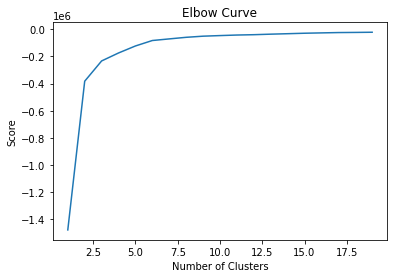

In [14]:
N = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in N]
kmeans
score = [kmeans[i].fit(sub_data).score(sub_data) for i in range(len(kmeans))]
score
plt.plot(N,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

del sub_data['Cluster']

In [15]:
km = KMeans(n_clusters=3)
km.fit(sub_data)
y = km.predict(sub_data)
labels = km.labels_
sub_data['Clusters'] = y

In [16]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(sub_data['Ward'])
y = np.array(sub_data['IUCR'])
z = np.array(sub_data['District'])

ax.set_xlabel('Ward')
ax.set_ylabel('IUCR')
ax.set_zlabel('District')

ax.scatter(x,y,z, marker="o", c = sub_data["Clusters"], s=60, cmap="winter")
ax.view_init(azim=0)
#print(ax.azim)
plt.show()

### The clustering does'nt seems to be based solely on the euclidean distances of IUCR codes now,

In [17]:
#Normalizing the time to be between 0 and 1, this way lower values would indicate midnight to early morning
#medium values would indicate the afternoon sessions, and high values would indicate evening and night time
#also kmeans then won't cluster just based on the time as the range of euclidean distances in time column will be very high without scaling
data['Normalized_time'] = (data['seconds'] - data['seconds'].min())/(data['seconds'].max()-data['seconds'].min())

In [19]:
sub_data1 = data[['IUCR', 'Normalized_time', 'District']]
sub_data1['IUCR'] = sub_data1.IUCR.str.extract('(\d+)', expand=True).astype(int)
sub_data1['IUCR'] = (sub_data1['IUCR'] - sub_data1['IUCR'].min())/(sub_data1['IUCR'].max()-sub_data1['IUCR'].min())
sub_data1['District'] = (sub_data1['District'] - sub_data1['District'].min())/(sub_data1['District'].max()-sub_data1['District'].min())
sub_data1.head()

<ipython-input-19-26fbb5f2a8d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['IUCR'] = sub_data1.IUCR.str.extract('(\d+)', expand=True).astype(int)
<ipython-input-19-26fbb5f2a8d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['IUCR'] = (sub_data1['IUCR'] - sub_data1['IUCR'].min())/(sub_data1['IUCR'].max()-sub_data1['IUCR'].min())
<ipython-input-19-26fbb5f2a8d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

IUCR  Normalized_time  District
0  0.091365         0.986796  0.300000
1  0.091365         0.903405  0.066667
2  0.088153         0.980542  0.466667
3  0.086145         0.924253  0.466667
4  0.158434         0.917304  0.466667

### Let's run KMeans on the above data now! Like before we shall start off by plotting the elbow curve to find the optimal number of clusters

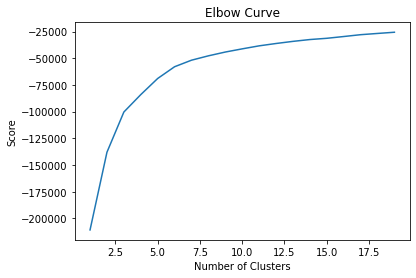

In [21]:
N = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in N]
kmeans
score = [kmeans[i].fit(sub_data1).score(sub_data1) for i in range(len(kmeans))]
score
plt.plot(N,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### The optimal number of clusters seem to be around 4-5, let's try it out with 4 first, and then we will plot the clusters on a 3d plot for 5 clusters as well and see how it turns out.

In [22]:
km = KMeans(n_clusters=4)
km.fit(sub_data1)
y = km.predict(sub_data1)
labels = km.labels_
sub_data1['Clusters'] = y
sub_data1.head()

<ipython-input-22-d3039a00eb58>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


IUCR  Normalized_time  District  Clusters
0  0.091365         0.986796  0.300000         3
1  0.091365         0.903405  0.066667         3
2  0.088153         0.980542  0.466667         1
3  0.086145         0.924253  0.466667         1
4  0.158434         0.917304  0.466667         1

In [23]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(sub_data1['Normalized_time'])
y = np.array(sub_data1['IUCR'])
z = np.array(sub_data1['District'])

ax.set_xlabel('Time')
ax.set_ylabel('IUCR')
ax.set_zlabel('District')

ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="jet")
ax.view_init(azim=-20)
#print(ax.azim)
plt.show()


### clustering by setting n_clusters=5

In [24]:
km = KMeans(n_clusters=5)
km.fit(sub_data1)
y = km.predict(sub_data1)
labels = km.labels_
sub_data1['Clusters'] = y
sub_data1.head()

<ipython-input-24-5308a5dd8542>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


IUCR  Normalized_time  District  Clusters
0  0.091365         0.986796  0.300000         1
1  0.091365         0.903405  0.066667         1
2  0.088153         0.980542  0.466667         0
3  0.086145         0.924253  0.466667         0
4  0.158434         0.917304  0.466667         0

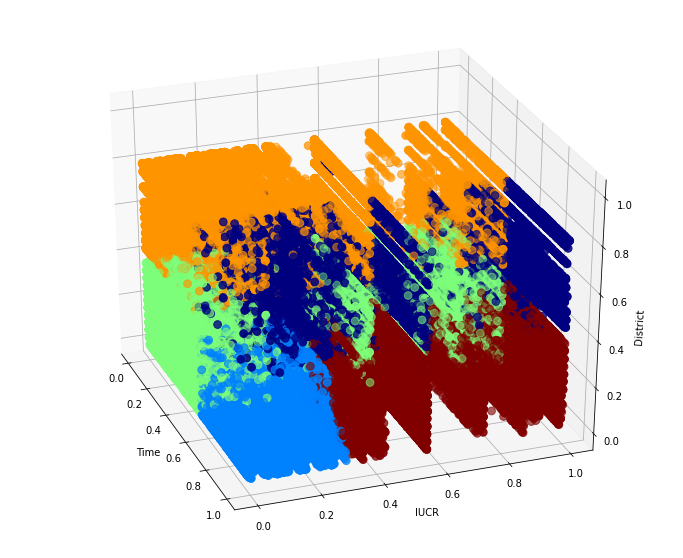

In [25]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(sub_data1['Normalized_time'])
y = np.array(sub_data1['IUCR'])
z = np.array(sub_data1['District'])

ax.set_xlabel('Time')
ax.set_ylabel('IUCR')
ax.set_zlabel('District')

ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="jet")
ax.view_init(azim=-20)
#print(ax.azim)
plt.show()